In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import os
import os.path as osp
import sys
import time
import glob
import cv2
from pathlib import Path
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

import torchvision
from torchvision import datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

from dataset import CVATDataset, COCODataset
from dataset import variable_shape_collate_fn


from utils import postprocessing, letterbox_transforms, letterbox_label_reverse, \
                  bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh, \
                  BoundingBoxType
from draw import show_img, draw_rect, draw_text, \
                 cv2_drawTextWithBkgd, get_color_pallete
from darknet import YoloNet
from train import *
import transforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Paths

In [5]:
weight_path = './yolov3.weights'
backbone_weight_path = './darknet53.conv.74'
classes_path = './x_wing.names'
classes_names = ['x_wing', 'tie']
cvat_img_dir = './custom_data/x_wing'
label_xml_path = './custom_data/7_x_wing.xml'
output_dir = './output'

In [6]:
cv2.setNumThreads(0)

# Training

## Set up dataloader

In [7]:
def getTransforms(dim, bbs_idx=np.arange(0,4), box_coord_scale='ratio', isAug=True):
    if isAug:
        transform = transforms.Compose([transforms.BasicAugmentations(),
                                        transforms.Letterbox(dim, box_coord_scale=box_coord_scale, bbs_idx=bbs_idx),
                                        transforms.ToTensor(),
                                      ])
    else:
        transform = transforms.Compose([transforms.Letterbox(dim, box_coord_scale=box_coord_scale, bbs_idx=bbs_idx),
                                         transforms.ToTensor(),
                                      ])
    return transform

def getData(sz, bs, shuffle=True, isAug=True):
    dim = (sz, sz)
    
    transform = getTransforms(dim, bbs_idx=np.arange(1,5), box_coord_scale='pixel', isAug=isAug)
    
    train_ds = CVATDataset(cvat_img_dir, label_xml_path, dim=dim, transform=transform)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=shuffle, num_workers=4)
    
    dataloader = dict()
    dataloader['train'] = train_dl
    dataloader['valid'] = None
    
    return dataloader

## Initial training

In [8]:
lr = 0.01
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001
yolo_lr = 0.01

In [5]:
epoch = 100
model_id = 'x_wing_4'
weight_dir_path = './weights'

remove_checkpoints(model_id, weight_dir_path)

net = YoloNet((sz, sz)).cuda()
net.feature.loadWeight(backbone_weight_path)

train(getData(sz, bs), net, epoch,
      lr, darknet53_lr, wd, momentum,
      0, 0, #lr_scheduler_decay_step, lr_scheduler_decay_gamma,
      model_id=model_id, start_epoch=0, weight_dir=weight_dir_path, checkpoint_interval=20,
      resume_checkpoint=None, use_gpu=True)

./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0079.pth.tar
./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0199.pth.tar
./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0179.pth.tar
./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0059.pth.tar
./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0019.pth.tar
./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0099.pth.tar
./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0119.pth.tar
./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0159.pth.tar
./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0039.pth.tar
./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0139.pth.tar
Epoch     loss_x    loss_y    loss_w    loss_h loss_conf  loss_cls loss_total    recall
    0  0.0007869 0.0007853 0.0005687 0.0005598 0.0512873 0.1186367  0.1726247 0.1579472                                                 
    1  0.0008015 0.0007994 0.0003917 0.0003665 0.0236802 0.0513686  0.0774079 0.1250623                                                 
    2  0.0007644 0.0007576 0.0002053 0.0001823 0

## Resume training (make sure 'model_id' matches)

In [8]:
def resume_training(max_epoch, model_id, weight_dir):
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    if pt_weight_path is not None:
        print('Loading %s' % pt_weight_path)
        
        checkpoint = load_checkpoint(pt_weight_path)
        net = YoloNet((sz, sz)).cuda()
                         
        train(getData(sz, bs), net, max_epoch,
              lr, darknet53_lr,
              wd, momentum,
              0, 0, #lr_scheduler_decay_step, lr_scheduler_decay_gamma,
              model_id=model_id, start_epoch=latest_epoch+1, weight_dir=weight_dir, checkpoint_interval=20,
              resume_checkpoint=checkpoint,
              use_gpu=True)
    else:
        print("No checkpoint for %d found" % model_id)

In [9]:
lr = 0.01
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001
yolo_lr = 0.01

In [10]:
#epoch 12 changed loss function
epoch = 200
model_id = 'x_wing_4'
weight_dir = './weights'
resume_training(epoch, model_id, weight_dir)

Loading ./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0099.pth.tar
Epoch     loss_x    loss_y    loss_w    loss_h loss_conf  loss_cls loss_total    recall
  100  0.0006015 0.0005867 0.0000169 0.0000164 0.0004106 0.0000825  0.0017145 0.8016941                                                 
  101  0.0006113 0.0006023 0.0000182 0.0000171 0.0004199 0.0000894  0.0017582 0.8071749                                                 
  102  0.0005965 0.0005942 0.0000150 0.0000161 0.0003980 0.0000819  0.0017017 0.8156452                                                 
  103  0.0006162 0.0006100 0.0000162 0.0000187 0.0004088 0.0000800  0.0017498 0.8126557                                                 
  104  0.0005895 0.0005865 0.0000157 0.0000165 0.0003961 0.0000929  0.0016972 0.8141505                                                 
  105  0.0006184 0.0006141 0.0000172 0.0000165 0.0004032 0.0001756  0.0018450 0.8241156                                                 
  106  0.0006057 0.0005

## Test model on images

In [10]:
def test_model(model_id, classes_names):
    sz = 416
    bs = 16
    dim = (sz, sz)
    
    weight_dir = './weights'
    output_dir = './output/' + model_id
    output_img_dir = output_dir + '/img'
    output_label_dir = output_dir + '/label'
    
    pt_weight_path, _ = get_latest_checkpoint(model_id, weight_dir)
    print('Loading %s' % pt_weight_path)
    checkpoint = load_checkpoint(pt_weight_path)
    
    dataloader = getData(sz, bs, shuffle=False, isAug=False)['train']
    net = YoloNet(dim).cuda().eval()
    net.load_state_dict(checkpoint['net'])
    
    write_detections(net, dataloader, output_img_dir, output_label_dir, classes_names)
    return output_img_dir, output_label_dir


def write_detections(net, dataloader, output_img_dir, output_label_dir, classes_names, font_scale=2.0, font=cv2.LINE_AA, line_width=4):
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)
    bbox_colors = get_color_pallete(20)
    
    with torch.no_grad(): 
        for batch, sample in enumerate(dataloader):          
            inp = sample['img']
            det1, det2, det3 = net(inp.cuda(), None)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), 80, obj_conf_thr=0.90, nms_thr=0.4)
            
            for i, (img, transform, img_path, predictions) in enumerate(zip(sample['org_img'], sample['transform'], sample['img_path'], predictions)):
                img = np.ascontiguousarray(img.numpy().transpose(1, 2, 0))
                img_w, img_h = img.shape[1], img.shape[0]
                labels = predictions.cpu()
                
                for l in labels:
                    box_coord = l[0:4]
                    cls = l[6]

                    cls_text = classes_names[cls.int().item()]
                    cls_color = bbox_colors[cls.int().item()].numpy().astype(np.float64)

                    # box_coord are interpreted as [x1,y1,x2,y2], reverse letterbox transform on the labels
                    resize_w, resize_h, x_off, y_off, ratio = letterbox_transforms((img_w, img_h), (net.img_dim[1], net.img_dim[0]))
                    ratio_x, ratio_y = img_w / resize_w, img_h / resize_h
                    box_coord[..., [0,2]] = (box_coord[..., [0,2]] - x_off) * ratio_x
                    box_coord[..., [1,3]] = (box_coord[..., [1,3]] - y_off) * ratio_y

                    pt1 = tuple(box_coord[0:2].int().numpy())
                    pt2 = tuple(box_coord[2:4].int().numpy())
                    
                    img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
                    img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img_w, img_h, font_scale=font_scale, font=font)
                
                img = (img * 255).astype(np.int32)
                img_name = Path(img_path).stem
                cv2.imwrite(osp.join(output_img_dir, img_name + '.jpg'), img)
                save_labels(osp.join(output_label_dir, img_name + '.txt'), labels)

            
def read_detections(img_dets_dir, idx=0, bs=4):
    img_dets_list = [osp.join(img_dets_dir, f) for f in os.listdir(img_dets_dir)]
    for i in range(idx, idx + bs):
        img_path = img_dets_list[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        show_img(img, figsize=(16,8))
    #return img_dets_list

def save_labels(save_path, labels, inp_fmt="x1 y1 x2 y2 conf cls clsId", out_fmt="clsId conf x1 y1 x2 y2"):
    if len(labels) == 0:
        return
    
    inp_dict = {v:i for i,v in enumerate(inp_fmt.split(' '))}
    out_list = out_fmt.split(' ')
    out_idx = [inp_dict[i] for i in out_list]
    out = labels[..., out_idx]
    fmt = []
    for o in out_list:
        if o == 'clsId':
            fmt.append('%d')
        else:
            fmt.append('%.6f')
    fmt = ' '.join(fmt)
    np.savetxt(save_path, out, fmt)

In [11]:
output_img_dir, output_label_dir = test_model('x_wing_4', classes_names)

Loading ./weights/x_wing_4/yolov3_x_wing_4_checkpoint_0199.pth.tar


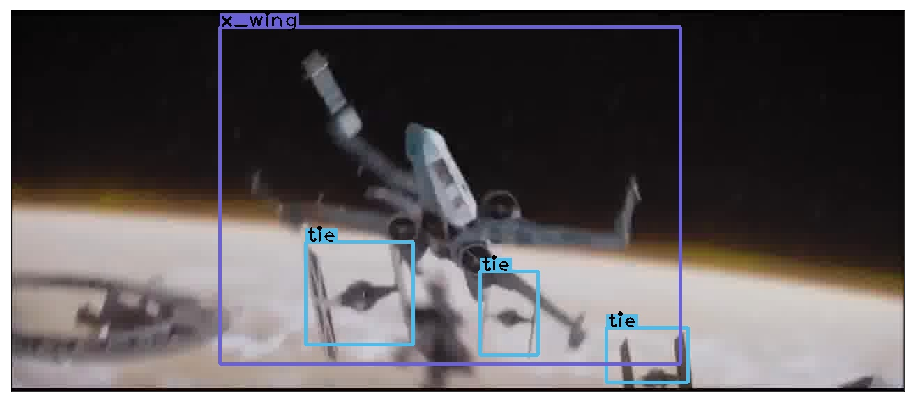

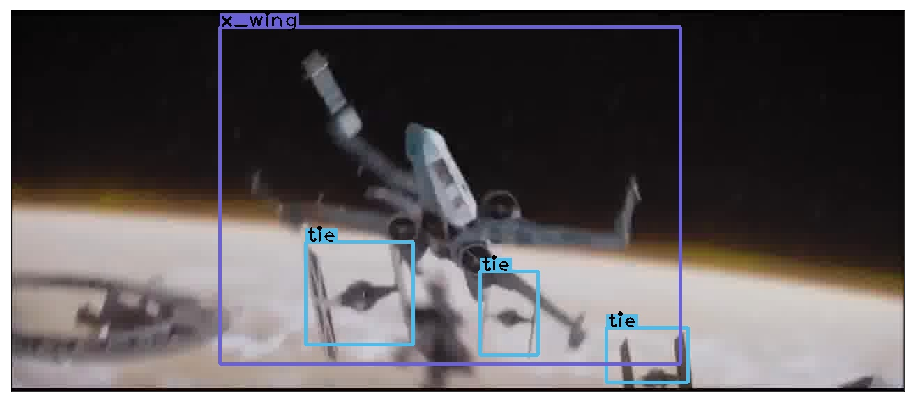

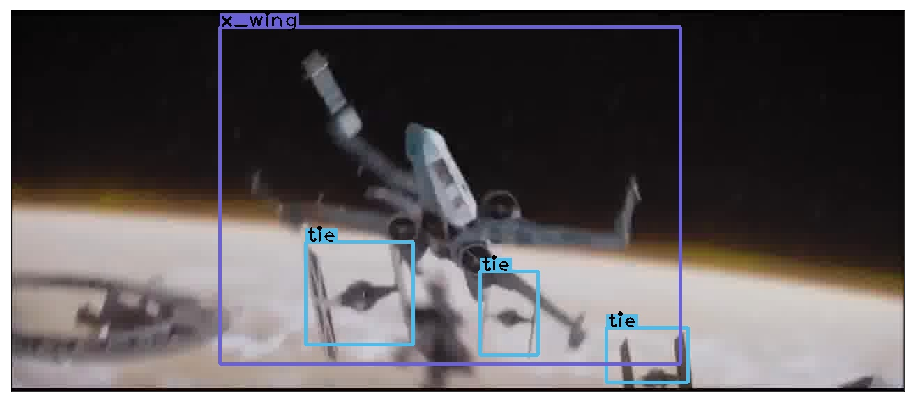

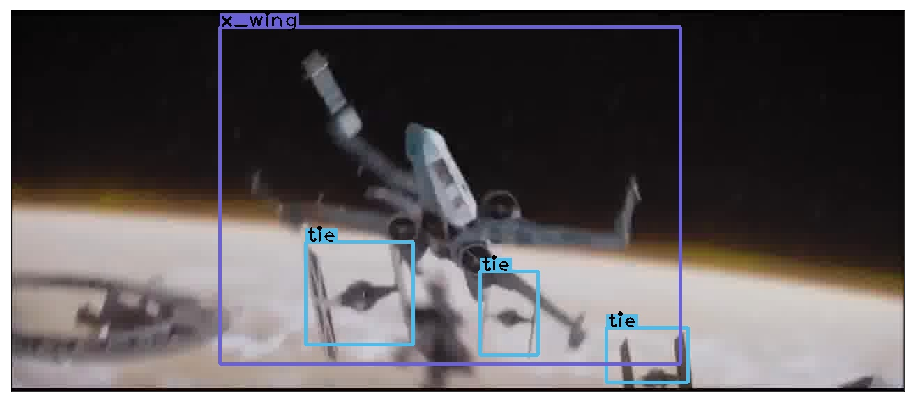

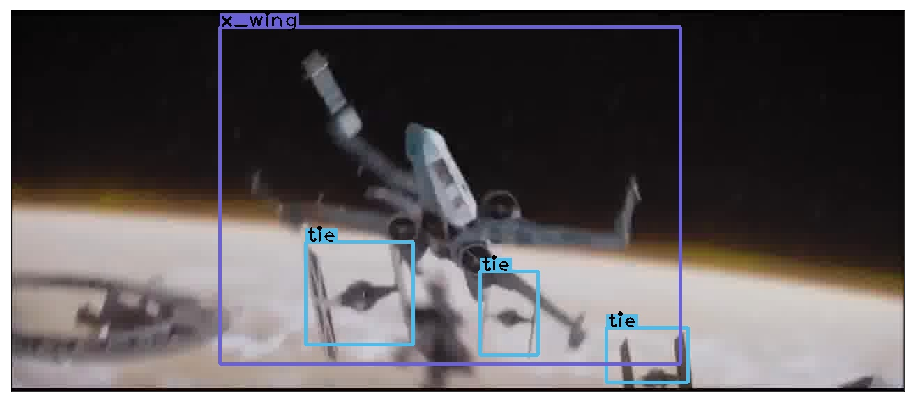

In [12]:
read_detections(output_img_dir, 5, 5)